# Multilayer perceptrons using *Tensorflow*

*Tensorflow* is an open source platform for machine learning, developed and used by Google. Tensorflow is more appropriate for *deep learning* (neural networks with multiple layers) and supports more complex architectures and more features than the multilayer perceptron available in *scikit-learn*. Unlike *scikit-learn*, *tensorflow* supports training on multiple computers and supports the use of GPUs (graphical processing units), which can process large blocks of data in parallel. For neural networks, *Tensorflow* is the preferred platform.


The steps for using *Tensorflow* for neural networks are as follows:

1. Scale the data
1. Build the model:
    1. create the model by using *model = Sequential()*
    1. add layers to the model using *model.add*, for example to add a *Dense* layer, or a *Conv2D* (convolutional) layer
1. Compile the model, using *model.compile*
1. Train the model using *model.fit*
1. Evaluate the model using *model.evaluate* or *model.predict* to measure performance


In this notebook we will user *Tensorflow* to create a multilayer perceptron to classify digits from tensorflow's version of the *MNIST* (Modified National Institute of Standards and Technology) database of handwritten digits. 


## Loading and understanding the data

The version of MNIST in *tensorflow* consists of 70,000 samples of 28 x 28 images. This dataset has more images than *scikit-learn*, and the images also have higher resolution (28x28 rather than 8x8). The images are already separated into training and testing sets.

In [1]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

*X_train* contains 60,000 images that are 28x28, and *y_train* contains the corresponding target values (digits 0 - 10)

In [2]:
print('X_train shape is: ', X_train.shape)
print('y_train shape is: ', y_train.shape)

X_train shape is:  (60000, 28, 28)
y_train shape is:  (60000,)


Let's plot the first 30 images

In [3]:
import matplotlib.pyplot as plt
figure, axes = plt.subplots(3,10, figsize = (15,6))

for ax,image,number in zip(axes.ravel(), X_train, y_train) :
    ax.axis('off')
    ax.imshow(image, cmap = plt.cm.gray_r)
    ax.set_title('Number: ' + str(number))

### Scale the data

Scaling the data often improves neural network performance by leading to better estimates for the weights and bias terms. Here we scale the data so that each pixel has a value between 0 and 1.

In [4]:
minimum = X_train.min()
maximum = X_train.max()

X_train = (X_train - minimum) / maximum
X_test = (X_test - minimum) / maximum

### Build the model

We build the model by first creating a *Sequential* model, and then adding the layers. The first 'layer' will flatten each 28x28 image to a 1D array containing the 784 pixel values. With *scikit-learn*, the features have to be flattened in advance; with *tensorflow* we can tell the model to flatten the features for us.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

mlp = Sequential()

mlp.add(Flatten(input_shape=(28, 28)))

In [6]:
28*28

784

Next we add a *dense* layer containing 100 nodes.

Every node in the previous layer is connected to each node in a dense layer. Each of the 784 features (input nodes) from the input layer are connected to each of the 100 nodes in this dense layer. For each node, the sum of weighted inputs is transformed using an *activation* function. The node outputs this transformed value. We will use the *rectified linear unit (relu)* activation function which has desirable properties that can lead to more efficient training.

In [7]:
mlp.add(Dense(100, activation='relu'))

We add another *dense* layer for our final output layer. The number of nodes in the output layer should be the same as the number of target values. We also use the *softmax* activation function which converts each output value to a probability so that all outputs sum to 1. When making predictions, the predicted target value corresponds to the node with the highest value.

In [8]:
mlp.add(Dense(10, activation = 'softmax'))

We can use the *summary* method to summarize our neural network. Note that our neural network has 79,510 parameters that must be learned! 

The *None* in the output shape corresponds to the number of training samples, which is not known in advance.

In [9]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


### Compile the model

To compile our model, we specify the following:

- the *optimizer* determines how the weights get updated. We will always use the 'adam' optimizer.
- the *loss* function, which is a measure of how well the neural network predicts the target values. The parameters are updated in a way that minimizes the loss function. We use 'sparse_categorical_crossentropy', which is appropriate for categorical target values, where each target value is represented by a number, and there are more than 2 categories.
- the *metrics* are evaluated by the model during training and testing



In [14]:
mlp.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

### Train the model

Train the neural network using the *fit* method. Recall that an *epoch* is a learning cycle that involves using *all* training samples to update the parameters (weights and biases) with the goal of minimizing the specified loss function. In practice the number of epochs should be high and stopping should be determined based on a validation accuracy (discussed more below). Training often involves thousands of epochs, and can take a considerable amount of time. Here, to get fast results, we use only 3 epochs (but still get good performance). 

The *fit* method returns a *history* object that stores the metrics and loss from the training process.

In [15]:
history = mlp.fit(X_train, y_train, epochs=3)
history

Epoch 1/3
60000/60000 [==============================] - 11s 191us/step - loss: 0.0706 - acc: 0.9785
Epoch 2/3
60000/60000 [==============================] - 10s 168us/step - loss: 0.0551 - acc: 0.9827
Epoch 3/3
60000/60000 [==============================] - 10s 171us/step - loss: 0.0448 - acc: 0.9864


### Evaluating the model

The *plot_loss_and_acc* function below plots loss and accuracy curves based on the history object from a trained neural network. Separate curves are drawn for the training and validation data, if available.

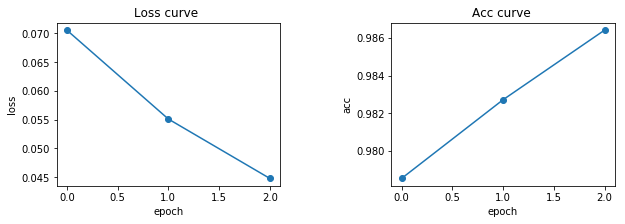

In [16]:
import matplotlib.pyplot as plt

# function to plot loss and accuracy curves
def plot_loss_and_acc(history, legend_loc = None) :
    
    if legend_loc is None :
        legend_loc = ['center', 'center']
    
    figure, axes = plt.subplots(1,2, figsize = (10,3))
    
    metrics = ['loss', 'acc']
    val_metrics = ['val_loss', 'val_acc']
    
    for i, (ax, metric, val_metric) in enumerate(zip(axes, metrics, val_metrics)) :
    
        # plot curve
        ax.plot(history.history[metric], marker = 'o', label = metric)
        ax.set_xlabel('epoch')
        ax.set_ylabel(metric)
        
        # add title
        title = metric.capitalize() + ' curve '
        ax.set_title(title)
    
        # if available, add validation loss curve
        if val_metric in history.history :
        
            ax.plot(history.history[val_metric], marker = 'o', label = val_metric)
            ax.legend(loc=legend_loc[i])

    # add some space in between plots
    plt.subplots_adjust(wspace=.5)
    
    
# plot curve
plot_loss_and_acc(history)

During training, training, we can include a validation dataset for which the loss and accuracy will be determined. If the loss decreases for the training but not the validation set, then you are overfitting the data. Similarly, if the accuracy increases for the training but not the validation set, then you are overfitting the data. 

In [18]:
history = mlp.fit(X_train, y_train, epochs=5, validation_data= (X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 168us/step - loss: 0.0639 - acc: 0.9806 - val_loss: 0.0839 - val_acc: 0.9730
Epoch 2/5
60000/60000 [==============================] - 10s 168us/step - loss: 0.0512 - acc: 0.9841 - val_loss: 0.0749 - val_acc: 0.9770
Epoch 3/5
60000/60000 [==============================] - 10s 166us/step - loss: 0.0413 - acc: 0.9873 - val_loss: 0.0764 - val_acc: 0.9762
Epoch 4/5
60000/60000 [==============================] - 10s 167us/step - loss: 0.0349 - acc: 0.9893 - val_loss: 0.0785 - val_acc: 0.9765
Epoch 5/5
60000/60000 [==============================] - 10s 165us/step - loss: 0.0282 - acc: 0.9913 - val_loss: 0.0759 - val_acc: 0.9767


Let's plot the curves. If the validation curve is much different than the training curve, we need better training data or a new model; if the validation curve does not improve, we may want to stop training early (for details on how this might be done, see https://lambdalabs.com/blog/tensorflow-2-0-tutorial-04-early-stopping/)

In [19]:
location = ['right', 'right']

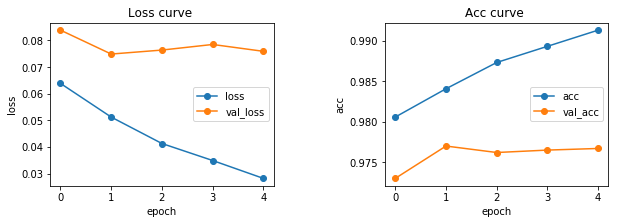

In [20]:
# plot curve
plot_loss_and_acc(history, legend_loc=location)

The *evaluate* method can be used to get the loss and accuracy in a test dataset

In [21]:
loss, acc = mlp.evaluate(X_test,  y_test, verbose=1)
print('accuracy is: ', acc)

10000/10000 [==============================] - 0s 36us/step
accuracy is:  0.9767


### Making predictions

The *predict* method will predict the outputs of the neural network. Specifically, this predicts the outputs of each node in the output layer. In this case, we have 10 nodes corresponding to probabilities for the digits 0 - 9. 

In [22]:
import pandas as pd
preds = mlp.predict(X_test[:3])
pd.DataFrame(preds.round(3))

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0
1,0.0,0.000,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
2,0.0,0.999,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0


If you just want the predicted classes, use *predict_classes*.

In [23]:
mlp.predict_classes(X_test[:3,])

array([7, 2, 1])